# **ESOL Solubility Dataset**

This dataset contains chemical compounds with both predicted and experimentally measured solubility in water, expressed in log scale. It includes molecular descriptors commonly used in cheminformatics and **QSAR** modeling.  

| Column Name                               | Description                                                                 |
|-------------------------------------------|-----------------------------------------------------------------------------|
| Compound ID                               | Unique identifier for each chemical compound.                                |
| ESOL predicted log solubility in mols/L  | Predicted solubility in water (log scale) based on molecular features.       |
| Minimum Degree                             | Minimum number of bonds connected to any atom in the molecule.              |
| Molecular Weight                           | Molecular mass of the compound (sum of atomic weights).                      |
| Number of H-Bond Donors                    | Number of atoms capable of donating hydrogen bonds (e.g., –OH, –NH).       |
| Number of Rings                            | Total number of ring structures in the molecule.                             |
| Number of Rotatable Bonds                  | Number of bonds that allow rotation, contributing to molecular flexibility. |
| Polar Surface Area                          | Surface area of polar atoms (O, N), influencing solubility.                 |
| Measured log solubility in mols/L         | Experimentally determined solubility of the compound (log scale).           |
| SMILES                                     | Text-based representation of the chemical structure.                         |

The dataset is used for building predictive models relating molecular structure to solubility.

---

In [ ]:
# Installing the necessary libraries
!pip install -q pandas numpy scikit-learn matplotlib seaborn rdkit shap

In [ ]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Descriptors

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score

import shap

import warnings
warnings.filterwarnings('ignore')

# **1) Data Audit & Validation**

In [ ]:
# Loding the dataset
df = pd.read_csv("ESOL.csv")

In [ ]:
# Checking the few rows in dataset
df.head()

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


In [ ]:
# Shape of dataset
df.shape

(1128, 10)

This dataset has: 1128 rows and 10 columns.

In [ ]:
# Checking the info of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 10 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Compound ID                                      1128 non-null   object 
 1   ESOL predicted log solubility in mols per litre  1128 non-null   float64
 2   Minimum Degree                                   1128 non-null   int64  
 3   Molecular Weight                                 1128 non-null   float64
 4   Number of H-Bond Donors                          1128 non-null   int64  
 5   Number of Rings                                  1128 non-null   int64  
 6   Number of Rotatable Bonds                        1128 non-null   int64  
 7   Polar Surface Area                               1128 non-null   float64
 8   measured log solubility in mols per litre        1128 non-null   float64
 9   smiles                        

**Based on the output of `df.info()`, we can gather the following insights**:

*   The dataset contains 1128 entries (rows) and 10 columns.
*   All columns have 1128 non-null values, indicating that there are no missing values in the dataset.
*   The columns have appropriate data types:
    *   `float64`: 'ESOL predicted log solubility in mols per litre', 'Molecular Weight', 'Polar Surface Area', and 'measured log solubility in mols per litre'. These represent numerical values with decimal points, suitable for quantitative analysis.
    *   `int64`: 'Minimum Degree', 'Number of H-Bond Donors', 'Number of Rings', and 'Number of Rotatable Bonds'. These represent whole numbers, likely counts or discrete measurements.
    *   `object`: 'Compound ID' and 'smiles'. These represent string or mixed data types, suitable for identifiers and chemical structure representations.
*   The memory usage of the DataFrame is approximately 88.3+ KB.

---

# **1.1) Generating Molecular Descriptors with RDKit**

**RDKit** is an open-source cheminformatics library used for processing and analyzing chemical structures. It can convert **SMILES representations** into molecular objects and compute a wide range of **molecular descriptors** such as:

- Molecular Weight  
- Number of H-Bond Donors  
- Number of Rings  
- Number of Rotatable Bonds  
- Polar Surface Area  

These descriptors quantitatively represent the chemical structure and properties of molecules. They are widely used as **input features in QSAR (Quantitative Structure-Activity Relationship) modeling** and other predictive machine learning tasks to relate molecular structure to properties like solubility, bioactivity, or toxicity.  

Using RDKit to generate these descriptors ensures **consistent, reproducible, and scalable feature extraction** from molecular data, which is critical for building accurate predictive models.


In [ ]:
# Function to compute descriptors
def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return pd.Series({
            'MolWt': Descriptors.MolWt(mol),
            'NumHDonors': Descriptors.NumHDonors(mol),
            'NumHAcceptors': Descriptors.NumHAcceptors(mol),
            'NumRings': Descriptors.RingCount(mol),
            'TPSA': Descriptors.TPSA(mol),
            'NumRotatableBonds': Descriptors.NumRotatableBonds(mol)
        })
    else:
        return pd.Series({
            'MolWt': None, 'NumHDonors': None, 'NumHAcceptors': None,
            'NumRings': None, 'TPSA': None, 'NumRotatableBonds': None
        })

descriptors = df['smiles'].apply(compute_descriptors)
data = pd.concat([df, descriptors], axis=1)
data = data.dropna()

In [ ]:
data.head()

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles,MolWt,NumHDonors,NumHAcceptors,NumRings,TPSA,NumRotatableBonds
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,457.432,7.0,12.0,3.0,202.32,7.0
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2,201.225,1.0,2.0,2.0,42.24,2.0
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O),152.237,0.0,1.0,0.0,17.07,4.0
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,278.354,0.0,0.0,5.0,0.00,0.0
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1,84.143,0.0,1.0,1.0,0.00,0.0


# **2) Data Cleaning**

In [ ]:
# Checking for null values
data.isnull().sum()

,0
Compound ID,0
ESOL predicted log solubility in mols per litre,0
Minimum Degree,0
Molecular Weight,0
Number of H-Bond Donors,0
Number of Rings,0
Number of Rotatable Bonds,0
Polar Surface Area,0
measured log solubility in mols per litre,0
smiles,0


There are no null values.

In [ ]:
# Checking for duplicates
data.duplicated().sum()

np.int64(0)

There are no duplicated

# **3) EDA**

#### 1) How do molecular properties such as Molecular Weight, TPSA, Number of H-Bond Donors/Acceptors, and Rotatable Bonds correlate with measured solubility?

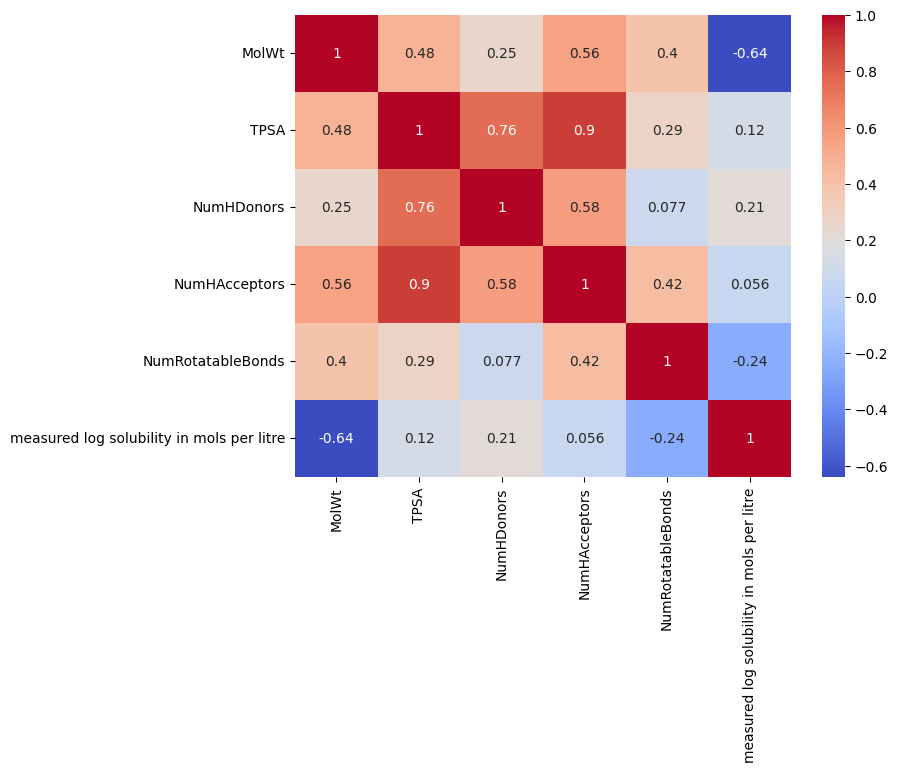

In [ ]:
cols = ['MolWt', 'TPSA', 'NumHDonors', 'NumHAcceptors', 'NumRotatableBonds', 'measured log solubility in mols per litre']

corr = data[cols].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

**Insights from Correlation Analysis:**

- **Molecular Weight (MolWt)**: Moderate negative correlation (-0.64) with solubility; larger molecules tend to be less soluble.  
- **Polar Surface Area (TPSA)**: Weak positive correlation (0.12); larger polar surface may slightly increase solubility.  
- **H-Bond Donors (NumHDonors)**: Weak positive correlation (0.21); more donors can enhance solubility via hydrogen bonding.  
- **H-Bond Acceptors (NumHAcceptors)**: Very weak positive correlation (0.06); minimal impact on solubility.  
- **Rotatable Bonds (NumRotatableBonds)**: Weak negative correlation (-0.24); increased flexibility slightly reduces solubility.  

**Summary:** Molecular Weight is the strongest predictor of solubility, while other descriptors have minor positive or negative effects.

---

#### 2) What is the distribution of key descriptors (e.g., MolWt, TPSA, NumRings) and are there any significant outliers?

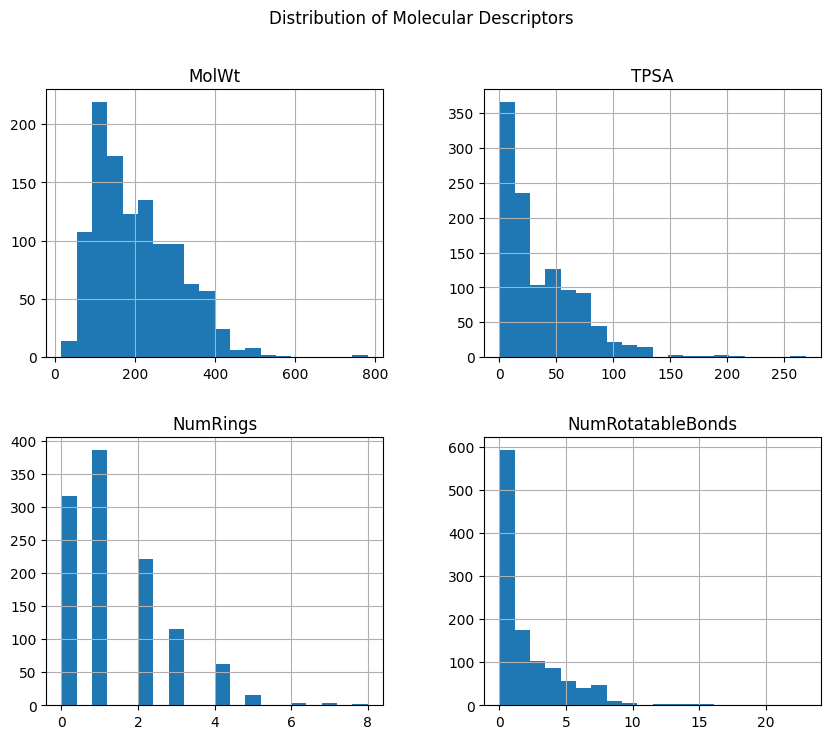

In [ ]:
descriptor_cols = ['MolWt', 'TPSA', 'NumRings', 'NumRotatableBonds']

data[descriptor_cols].hist(figsize=(10,8), bins=20)
plt.suptitle("Distribution of Molecular Descriptors")
plt.show()

**Insights from Descriptor Distributions:**

- **Molecular Weight (MolWt):** Right-skewed; most compounds have lower molecular weights, with a few high-weight outliers.  
- **Polar Surface Area (TPSA):** Right-skewed; majority of compounds have low TPSA, with some more polar compounds in the tail.  
- **Number of Rings (NumRings):** Skewed towards 0–1 rings; most compounds are acyclic or contain a single ring.  
- **Number of Rotatable Bonds (NumRotatableBonds):** Right-skewed; many molecules have limited flexibility, with a few highly flexible ones.  

**Summary:** The distributions highlight typical cheminformatics patterns with skewed data and potential outliers, suggesting careful consideration during modeling or feature transformation.

---

#### 3) How well does ESOL predicted log solubility match the measured solubility across different classes of compounds (e.g., high molecular weight vs low, high TPSA vs low)?

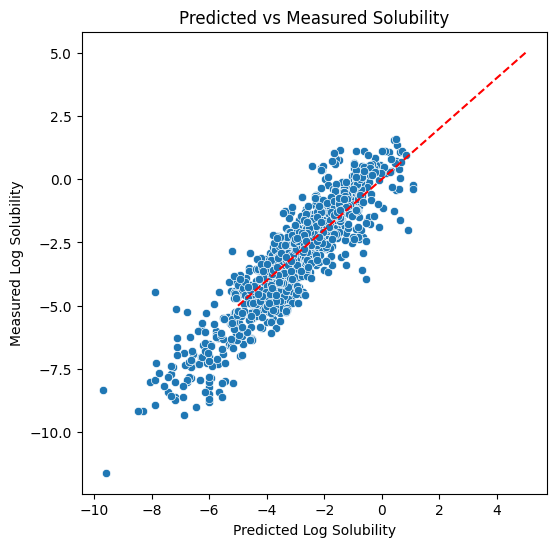

In [ ]:
plt.figure(figsize=(6,6))
sns.scatterplot(
    x='ESOL predicted log solubility in mols per litre',
    y='measured log solubility in mols per litre',
    data=data
)
plt.plot([-5,5], [-5,5], 'r--')  # reference line
plt.xlabel("Predicted Log Solubility")
plt.ylabel("Measured Log Solubility")
plt.title("Predicted vs Measured Solubility")
plt.show()


**Insights from Predicted vs Measured Solubility Plot:**

- **General Agreement:** Predicted solubility values are generally close to measured values, clustering around the reference line.  
- **Spread Around the Line:** Some deviations exist, indicating varying prediction accuracy across compounds.  
- **Potential Outliers:** A few points lie far from the reference line, suggesting certain compounds are less accurately predicted.  
- **Range of Solubility:** The dataset spans a wide range of solubility values, covering diverse compounds.  
- **Linear Relationship:** Overall, a roughly linear trend is observed between predicted and measured values.  

**Summary:** The plot confirms that the ESOL model predicts solubility reasonably well, with some variability and room for improvement for outlier compounds.

---

#### 4) Are there multicollinearity patterns among descriptors (e.g., MolWt vs NumRings or TPSA vs NumHDonors)?

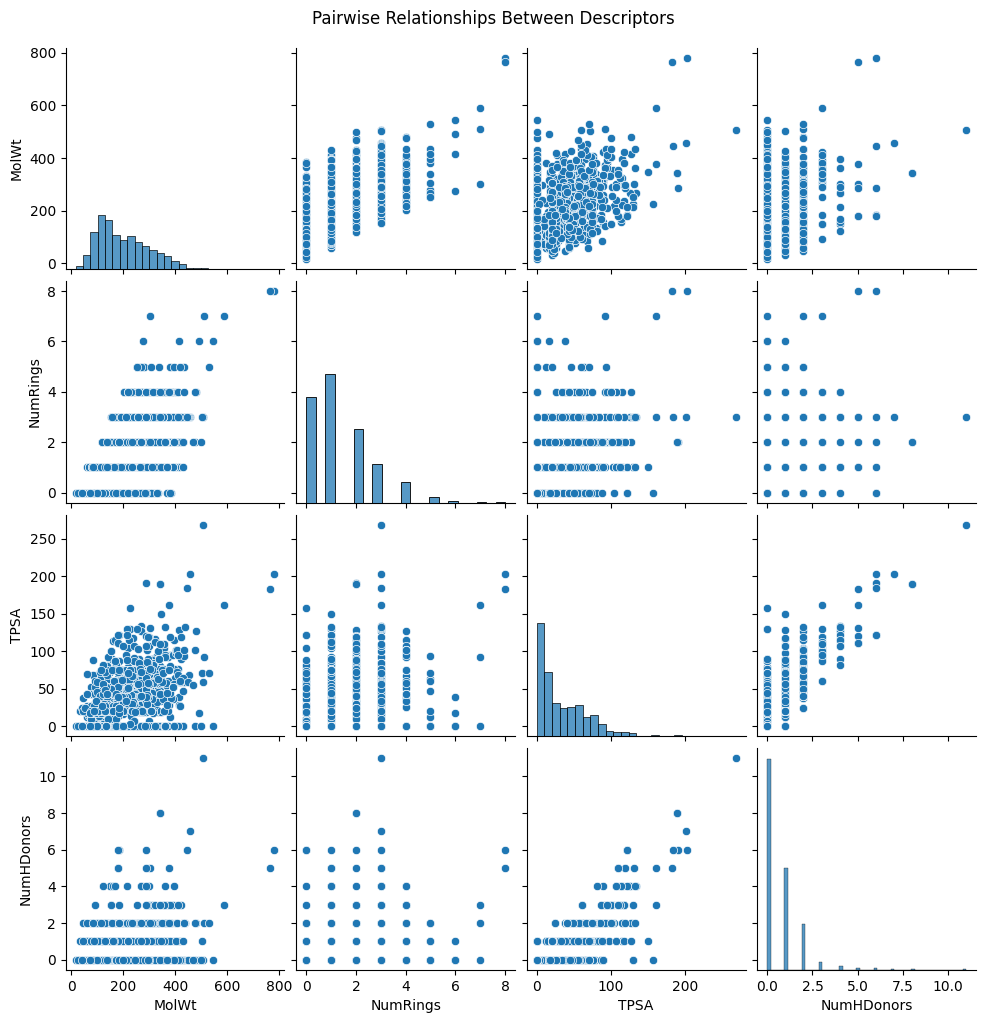

In [ ]:
sns.pairplot(data[['MolWt','NumRings','TPSA','NumHDonors']])
plt.suptitle("Pairwise Relationships Between Descriptors", y=1.02)
plt.show()

**Insights from Pairwise Relationships:**

- **MolWt vs. NumRings:** Positive correlation; molecules with more rings tend to have higher molecular weight.  
- **MolWt vs. TPSA:** Moderate positive correlation; larger molecules often have greater polar surface area.  
- **MolWt vs. NumHDonors:** Weak positive correlation; larger molecules may have more H-bond donors.  
- **NumRings vs. TPSA:** Weak positive correlation; ring structures may contribute some polar functional groups.  
- **NumRings vs. NumHDonors:** Weak positive correlation; rings can contain functional groups that donate H-bonds.  
- **TPSA vs. NumHDonors:** Strong positive correlation; hydrogen bond donors largely contribute to polar surface area.  

**Summary:** The pairplot confirms expected relationships among descriptors. TPSA and NumHDonors are strongly correlated, indicating overlap in molecular polarity representation. Multicollinearity is minimal concern for tree-based models like Random Forest.

---

#### 5) How do measures of molecular complexity (e.g., NumRings, NumRotatableBonds, TPSA) relate to solubility trends?

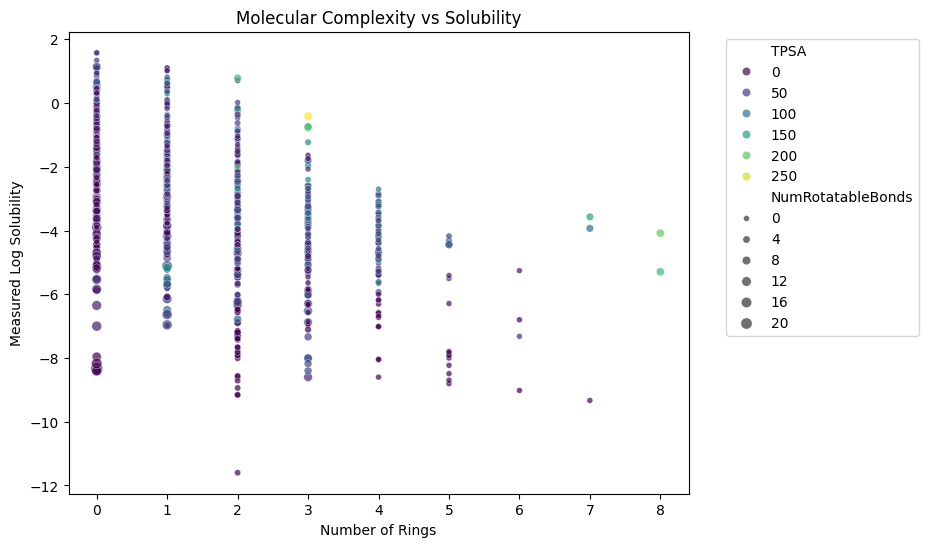

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='NumRings',
    y='measured log solubility in mols per litre',
    size='NumRotatableBonds',
    hue='TPSA',
    data=data,
    palette='viridis',
    alpha=0.7
)
plt.xlabel("Number of Rings")
plt.ylabel("Measured Log Solubility")
plt.title("Molecular Complexity vs Solubility")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()


**Insights from Molecular Complexity vs Solubility Plot:**

- **Number of Rings vs. Solubility:** No clear linear relationship; compounds with more rings may trend toward lower solubility.  
- **TPSA Influence (Color):** Higher TPSA compounds tend to have higher solubility, highlighting the role of polarity.  
- **Rotatable Bonds Influence (Size):** Number of rotatable bonds has a subtle effect; may slightly modify solubility when combined with other descriptors.  
- **Complexity and Solubility:** Solubility depends on a combination of molecular complexity and polarity. Compounds with more rings and lower TPSA are less soluble, while fewer rings and higher TPSA increase solubility.  

**Summary:** The plot shows that solubility is determined by multiple molecular features collectively, rather than by any single descriptor alone.

---

# **4) Model Training**

In [ ]:
# Splitting

X = data[['MolWt','NumHDonors','NumHAcceptors','NumRings','TPSA','NumRotatableBonds']]
y = data['measured log solubility in mols per litre']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Define models to try
models = {
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, random_state=42),
    "Extra Trees": ExtraTreesRegressor(n_estimators=200, random_state=42)
}

# Loop over models
for name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Print results
    print(f"--- {name} ---")
    print(f"RMSE: {rmse:.3f}")
    print(f"R2 Score: {r2:.3f}\n")

--- Random Forest ---
RMSE: 0.911
R2 Score: 0.825

--- Gradient Boosting ---
RMSE: 0.837
R2 Score: 0.852

--- Extra Trees ---
RMSE: 0.883
R2 Score: 0.835



## **Model Evaluation Results and Interpretation**

**Regression models were evaluated using RMSE and R² score:**

| Model               | RMSE   | R² Score |
|--------------------|--------|----------|
| Random Forest       | 0.911  | 0.825    |
| Gradient Boosting   | 0.837  | 0.852    |
| Extra Trees         | 0.883  | 0.835    |

**Interpretation:**

- **RMSE:** All models show low errors; Gradient Boosting has the lowest RMSE, indicating slightly better accuracy.  
- **R² Score:** All models explain a significant portion of variance (>0.8); Gradient Boosting performs best.  

**Choosing Random Forest:**  
Despite Gradient Boosting slightly outperforming, Random Forest is robust, parallelizable, handles non-linear interactions well, and is less prone to overfitting, making it a reliable choice.  

**Conclusion:**  
All three tree-based models perform well for solubility prediction. Gradient Boosting is marginally better, but Random Forest offers a strong, stable, and practical solution.

---

# **5) Feature Importance / Explainability**

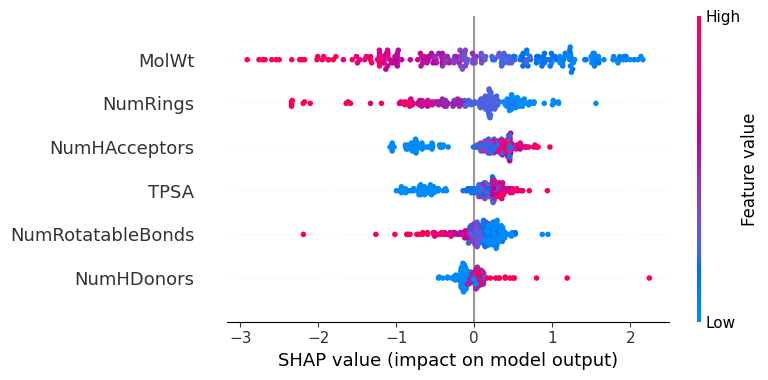

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

**Insights from SHAP Summary Plot:**

- **Feature Importance:** Features are ranked by average absolute SHAP values; the top features have the greatest impact on predictions.  
- **Key Feature Impacts:**  
  - **MolWt:** Most important; higher values decrease predicted solubility, lower values increase it.  
  - **TPSA:** Higher polar surface area increases solubility, lower decreases it.  
  - **NumRotatableBonds:** More rotatable bonds decrease solubility, fewer increase it.  
  - **NumHDonors:** More hydrogen bond donors increase solubility, fewer decrease it.  
  - **NumRings:** Moderate impact; effect varies by compound.  
  - **NumHAcceptors:** Least impactful; SHAP values near zero.  
- **Direction of Impact:** Point color indicates feature value (red = high, blue = low); x-axis shows effect on predicted solubility (positive = increases, negative = decreases).  

**Summary:** The SHAP plot highlights that MolWt, TPSA, and NumRotatableBonds are the most influential descriptors, confirming trends observed in correlation analysis and providing detailed insights into feature contributions for individual predictions.

---

## **Conclusion, Insights, and Recommendations**

### **Conclusion**
The ESOL dataset was explored using molecular descriptors generated with RDKit and modeled using tree-based regression algorithms. Key findings include:

- Molecular Weight (MolWt), Polar Surface Area (TPSA), and Number of Rotatable Bonds (NumRotatableBonds) are the most influential descriptors affecting solubility predictions.
- Tree-based models (Random Forest, Gradient Boosting, Extra Trees) all demonstrated strong predictive performance, with Gradient Boosting slightly outperforming in RMSE and R², while Random Forest offers robustness and interpretability.
- SHAP and correlation analyses confirm expected chemical relationships: heavier molecules and more flexible molecules tend to be less soluble, while polarity and hydrogen-bond donors enhance solubility.

### **Key Insights**
1. **Feature Importance and Relationships**
   - MolWt shows a moderate negative correlation with solubility; larger molecules are less soluble.
   - TPSA and NumHDonors positively influence solubility, highlighting the role of polarity.
   - NumRotatableBonds negatively impacts solubility, indicating molecular flexibility reduces solubility.
   - NumHAcceptors and NumRings have minor or mixed effects individually.

2. **Descriptor Distributions**
   - Molecular descriptors are right-skewed, typical of cheminformatics datasets.
   - Most molecules are small, acyclic, or contain a single ring, with limited flexibility.

3. **Model Performance**
   - All three tree-based models achieved R² > 0.82 and low RMSE (<0.91), validating the use of selected molecular descriptors for QSAR-based solubility prediction.
   - SHAP analysis provides detailed interpretability, confirming chemical intuition regarding feature effects.

4. **Complexity and Combined Effects**
   - Solubility is influenced by multiple descriptors collectively rather than a single feature.
   - Visual analyses (pairplots, scatter plots, molecular complexity plots) highlight interactions between molecular weight, TPSA, rotatable bonds, and rings in determining solubility.

### **Recommendations**
- **Modeling:** Random Forest is recommended for production due to robustness, parallelization, and interpretability, though Gradient Boosting may be explored for marginal performance gains.
- **Feature Engineering:** Consider creating interaction or composite features (e.g., MolWt/TPSA ratio) to capture complex relationships.
- **Data Handling:** Skewed descriptor distributions suggest potential benefits from transformations (e.g., log-transform) or robust modeling techniques.
- **Outlier Analysis:** Investigate compounds that deviate significantly in predicted vs measured solubility to identify unique chemical patterns or data quality issues.
- **Deployment:** Integrate the predictive model with an interactive dashboard (e.g., Streamlit) and optional LLM insights for enhanced chemical interpretation.

**Summary:**  
The combined EDA, modeling, and interpretability analyses confirm that molecular descriptors effectively capture solubility trends. Tree-based models provide reliable predictions, and careful consideration of feature interactions and outliers can further enhance model accuracy and applicability in real-world chemical datasets.
